## Generates configurations and stores them to be used by the simulation program

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
import json
import datetime
import os
import utility_functions as utility
import pandas as pd

In [13]:
param_dict = {
    '[2].State.Mass.Value': [0.0,100.0], # Mass
    '[2].Components.[4].Component.RotationVelocityMax': [0.0,math.pi],
    '[2].Components.[4].Component.VelocityMax': [0.0,100.0],
    '[2].Components.[4].Component.RotationForceMax': [0.0,10.0],
    '[2].Components.[4].Component.LinearForceMax': [0.0,10.0],
    '[2].Components.[4].Component.EnergyLoss': [0.0,1.0]
}

base_path = 'Samples/data.json'

Latin Hypercube based Configuration generation

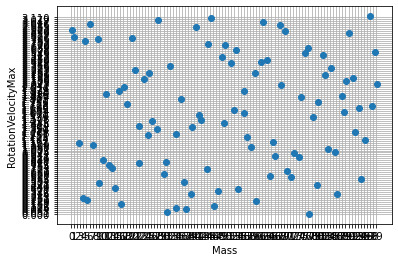

In [7]:
# taken from this example: https://smt.readthedocs.io/en/latest/_src_docs/sampling_methods/lhs.html

xlimits = np.array(list(param_dict.values()))
sampling = LHS(xlimits=xlimits, criterion='corr')

num = 100
lhs_samples = sampling(num)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(0.0,100.0, 100/num))
ax.set_yticks(np.arange(0.0,math.pi, math.pi/num))
ax.grid()
plt.plot(lhs_samples[:, 0], lhs_samples[:, 1], "o")
plt.xlabel('Mass')
plt.ylabel('RotationVelocityMax')
plt.show()

Testing different values for consumption rate

In [15]:
energy_consumption_path = '[2].State.ConsumptionRate.Value'

data = utility.get_config(base_path)
initial_consumption = utility.get_json_value(data, energy_consumption_path)
i = 0
basePath = os.path.join('Samples',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(basePath, exist_ok=True)
utility.set_json_value(data, energy_consumption_path, initial_consumption*0.6)
for sample in lhs_samples:
    utility.create_config(data, param_dict.keys(), sample)
    utility.save_config(os.path.join(basePath,'sample_' + str(i) + '.json'), data)
    i += 1

Generating Configuration from Metadata

In [11]:
param_mapping_dict = {
    '[2].State.Mass.Value': 'Mass',
    '[2].Components.[4].Component.RotationVelocityMax': 'RotationVelocityMax',
    '[2].Components.[4].Component.VelocityMax': 'VelocityMax',
    '[2].Components.[4].Component.RotationForceMax': 'RotationForceMax',
    '[2].Components.[4].Component.LinearForceMax': 'LinearForceMax',
    '[2].Components.[4].Component.EnergyLoss': 'EnergyLoss',
    '[2].State.ConsumptionRate.Value' : 'ConsumptionRate'
}

df = pd.read_csv('../SampleMetadata/result_and_meta.csv')
df.set_index(['Run_Id','Sample_Id'],inplace=True)
top = df.sort_values('Energy_mean', ascending=False).head(25)
mapped_values = pd.concat([pd.Series(param_mapping_dict.keys(), param_mapping_dict.values()).rename('Path'),
                           top.mean().rename('Mean'), top.min().rename('Min'), top.max().rename('Max')], axis=1).dropna()

Energy_mean                 0.082068
Energy_std                  0.886679
Energy_max                 41.484250
Total_Cycles           212430.000000
Energy_Cycles            2767.040000
Energy_Ratio                0.013026
Mass                       19.733258
RotationVelocityMax         0.729203
VelocityMax                50.272869
RotationForceMax            4.874492
LinearForceMax              5.826845
EnergyLoss                  0.161129
ConsumptionRate             1.610000
dtype: float64

In [47]:
basePath = 'Samples/Top_Run'
os.makedirs(basePath, exist_ok=True)
base_config = utility.get_config(base_path)
for column in mapped_values.columns:
    if column == 'Path':
        continue
    utility.create_config(base_config, mapped_values['Path'].values, mapped_values[column].values)
    utility.save_config(os.path.join(basePath, 'Sample_'+column+'.json') ,base_config)